# plot the row sum difference of embeddings

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans

from graspologic.embed import AdjacencySpectralEmbed
from graspologic.simulations import sbm
from graspologic.plot import heatmap, pairplot

import warnings
warnings.filterwarnings('ignore')
np.random.seed(8889)
import matplotlib.lines as mlines
%matplotlib inline

import networkx as nx
from scipy.sparse import csr_array
from graspologic.simulations import rdpg
#from scipy.linalg import irlba
#from scipy.spatial import procrustes
%run GraphEncoder.ipynb
import leidenalg as la
import igraph as ig
import scipy.sparse as sp
import random
import math
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F

from gae.layers import GraphConvolution
from gae.model import GCNModelVAE
from gae.utils import load_data, mask_test_edges, preprocess_graph, get_roc_score
from gae.optimizer import loss_function

/Users/tongqi/miniforge3/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/tongqi/miniforge3/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/tongqi/miniforge3/lib/python3.9/site-packages/umap/distances.py:1086: NumbaDeprecatio

In [3]:
# Define all the functions 
def sample_dot_product(lpvs):
        num_nodes = lpvs.shape[1]
        similarity_matrix = np.dot(lpvs.T, lpvs)
        np.fill_diagonal(similarity_matrix, 0)  # Remove self-similarity
        return nx.Graph(similarity_matrix)

def adj_to_edg(A):
    """
      input is the symmetric adjacency matrix: A
      other variables in this function:
      s: number of edges
      return edg_list -- matrix format with shape(edg_sum,3):
      example row in edg_list(matrix): [vertex1, vertex2, connection weight from Adj matrix]
    """
    # check the len of the second dimenson of A
    if A.shape[1] <= 3:
      edg = A
    else:
      n = A.shape[0]
      # construct the initial edgg_list matrix with the size of (edg_sum, 3)
      edg_list = []
      for i in range(n):
        for j in range(i, n):
          if A[i,j] > 0:
            row = [i, j, A[i,j]]
            edg_list.append(row)
      edg = np.array(edg_list)
    return edg

def procrustes(X, Y, type="I"):
    if type == "C":
        X = X / np.linalg.norm(X, "fro") * np.sqrt(X.shape[0])
        Y = Y / np.linalg.norm(Y, "fro") * np.sqrt(Y.shape[0])
    if type == "D":
        tX = np.sum(X ** 2, axis=1)
        tX[tX <= 1e-15] = 1
        tY = np.sum(Y ** 2, axis=1)
        tY[tY <= 1e-15] = 1
        X = X / np.sqrt(tX)[:, np.newaxis]
        Y = Y / np.sqrt(tY)[:, np.newaxis]

    tmp = X.T @ Y
    U, s, Vt = np.linalg.svd(tmp,full_matrices=True)
    W = U @ Vt ########
    error = np.linalg.norm(X @ W - Y, "fro")
    
    return {"error": error, "W": W}

def GCN_emb(model, features, adj_norm_matrix, adj_label,n, decay,learning_rate, epochs = 200):
    optimizer = torch.optim.Adam(
      model.parameters(),
      lr=learning_rate,
      weight_decay=decay) #weight decay is important!

    # get class weight
    pos_weight = ((adj_label.shape[0] * adj_label.shape[0] - adj_label.sum()) / adj_label.sum())
    # get adj norm
    adj_norm = adj_label.shape[0] * adj_label.shape[0] / float((adj_label.shape[0] *adj_label.shape[0] - adj_label.sum()) * 2)

    # Training the VAE   
    while True: #we can try 20 different random weight init runs to get an average 
        # initialize weights randomly => impact on convergence
        model.gc1.reset_parameters()
        model.gc2.reset_parameters()
        model.gc3.reset_parameters()  
        # Training
        for epoch in range(0, epochs + 1):
            model.train()
            optimizer.zero_grad()
            # ===================forward=====================
            adj_hat, mu, logvar = model(features,adj_norm_matrix)        
            loss = loss_function(adj_hat,adj_label,mu,logvar,n,adj_norm,pos_weight) #might reduce the KL term regularization
            # log
            if epoch == 0:
              init_loss = loss.item()
            # if epoch% 50 == 0:
            #   print('loss: ', loss.item())
            # ===================backward====================
            loss.backward()
            optimizer.step()
        # Check convergence
        if (init_loss-loss.item())/loss.item() > 0.05: 
            break
        else:
          print(model)
          print('not converged yet, reset params and rerun')

  # Get GCN embedding
    with torch.no_grad():
      model.eval()
      adj_hat, mu, logvar = model(features, adj_norm_matrix)
      z = model.reparameterize(mu, logvar) 

    return z

def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

def preprocess_graph(adj_):
    rowsum = np.array(adj_.sum(1))
    degree_mat_inv_sqrt = sp.diags(np.power(rowsum, -0.5).flatten()) #D^-0.5
    adj_normalized = adj_.dot(degree_mat_inv_sqrt).transpose().dot(degree_mat_inv_sqrt).tocoo()  #D^-0.5 A D^-0.5
    return sparse_mx_to_torch_sparse_tensor(adj_normalized), sparse_mx_to_torch_sparse_tensor(adj_)

def adj_in_out(adj):
    row, col = np.where(adj)
    coo = np.rec.fromarrays([row, col, adj[row, col]], names='row col value'.split())
    out = sp.coo_matrix((coo['value'], (coo['row'], coo['col'])), (adj.shape[0], adj.shape[1]))
    #Adjacency normalized matrix and label for GVAE usage
    adj_norm_matrix, adj_matrix = preprocess_graph(out)
    adj_label = torch.FloatTensor(out.toarray())
    return adj_norm_matrix, adj_matrix, adj_label#, out

def ARDPG(n,k):
    A = np.zeros((n,n))
    X = np.random.uniform(0.0, 1.0, (n,1))
    for i in range(0,n):
        if y[i] == 1:
            X[i,:] = np.random.beta(1,3)
        elif y[i] == 2:
            X[i,:] = np.random.beta(3,3)
        else:
            X[i,:] = np.random.beta(3,1)
    P=np.matmul(X,X.transpose())
    for i in range(0,n):
        for j in range(1,n):
            A[i,j]=np.random.binomial(1,P[i,j])
    for i in range(0,n):
        for j in range(0,i):
            A[i,j] = A[j,i]
            A[i,i]=0
    return A

def gety(n):
    y = np.zeros((n,1))
    #np.random.seed(2)
    for i in range(0,n):
        y[i,0] = np.random.choice(np.arange(1, 4), p=[0.2, 0.3,0.5])
    return(y)

def latent3y(n):
    X1 = np.random.dirichlet((2,1,1),int(n/3))
    X2 = np.random.dirichlet((1,1,2),int(n/3))
    X3 = np.random.dirichlet((1,2,1),(n-int(n/3)*2))
    together = np.concatenate((X1, X2,X3))
    latent = np.delete(together, 2, 1)
    ty = [1,2,3]
    y = np.repeat(ty, n/3)
    return(latent,y)
  

## RDPG with no cluster to $R^2$ and $R^3$
## fixed randomly selected clique vertices


In [74]:
# RDPG no cluster
# calculate row sum
# R^2
# Adj clique

#nvs = np.arange(100, 1501, 200)

nvs = np.arange(1000, 1001, 2)
sim = 50
random.seed(118)

ASE_dist = []
ASE_nml = []
GEE_dist = []
GEE_nml = []
GAE_dist = []
GAE_nml = []
GEE_dist2 =[]
GEE_fnorm2 =[]
n_vs = []

GEE_fnorm = []
GAE_fnorm = []

adj0_norms = []

RSD_afterASE = []
RSD_afterGEE1 = []
RSD_afterGEE2 = []
RSD_afterGAE = []

d = 2

#sim_alldata = pd.DataFrame()
sim_alldata_nml = []

for n in nvs:
    #_____________________ clique size
    ratio = 0.2      
    cliquesize =f'log(n)^2'      #!!    f'{ratio}*n'
    clique_size = math.log(n)     #math.log(n)           #   ratio*n 
    num_vertices = int(clique_size) 
    c_vertices = np.arange(0,num_vertices) 
        
    for i in range(sim):
        lpvs = np.random.dirichlet((1,1,1),n) 
        lpvs = np.delete(lpvs, 2, 1)
        g = rdpg(lpvs,loops=False)
        g.astype(int)
        adj0 = csr_array(g)
        graph0 = nx.from_numpy_matrix(g,parallel_edges=False, create_using=None)
        
        adj0_norm = sp.linalg.norm(adj0)
        adj0_norms.append(adj0_norm)

#         ########## change clique size ##################################
#         ratio = 0.2      
#         cliquesize =f'log(n)^2'      #!!    f'{ratio}*n'
#         clique_size = ratio*n   #math.log(n)           #   ratio*n 
#         num_vertices = int(clique_size) 
#         #################  change location of vertices##################
#         c_vertices = np.arange(0,num_vertices)  
#         #c_vertices = np.arange(n-num_vertices,n)  
#         #c_vertices = random.sample(range(0,n),num_vertices)
        ################################################################
        full_g = nx.complete_graph(c_vertices)
        
        full_edges = list(full_g.edges())
        edges = list(graph0.edges()) 
        all_edges = set(full_edges).union(set(edges))
        
        graph1 = nx.Graph()
        graph1.add_nodes_from(sorted(graph0.nodes(data=True)))
        graph1.add_edges_from(all_edges)
        
        adj1 = nx.to_numpy_array(graph1, dtype=int)

        ##############  ASE  ######################3
        d = d
        ase = AdjacencySpectralEmbed(n_components=d, algorithm='truncated')
        ASE_Xhat0 = ase.fit_transform(adj0)

        ASE_Xhat1 = ase.fit_transform(adj1)

        #pairplot(Xhat0, title='2-component embedding', height=2)
        ASE_d = procrustes(ASE_Xhat1,ASE_Xhat0)
        ASE_dd = ASE_d['error']
        ASE_dist.append(ASE_dd)
        
#         ASE_n = ASE_dd/adj0_norm
#         ASE_nml.append(ASE_n)

        ############## row sum after ASE
        
        row_1 = np.sum((ASE_Xhat0 - ASE_Xhat1.dot(ASE_d['W']))**2, axis=1)
        RSD_afterASE.append(row_1)

        ############ GEE ##################
        edgelist0 = adj_to_edg(adj0)
        i_graph0 = ig.Graph.from_networkx(graph0)
        y0 = la.find_partition(i_graph0, la.ModularityVertexPartition)
        #y0 = la.find_partition(i_graph0,la.CPMVertexPartition,resolution_parameter = 0.015)
        label_num = []
        for k in range(len(y0)):
            y = len(y0[k])
            label_num.append(y)
        values = np.arange(len(label_num))
        label0 = np.repeat(values, label_num) 
        label0= label0.reshape((n,1))
        Z0,W0 = graph_encoder_embed(edgelist0,label0,n,correlation=False)

        edgelist1 = adj_to_edg(adj1)
        i_graph1 = ig.Graph.from_networkx(graph1)
        n_comms = len(label_num)
        y1 = la.CPMVertexPartition(i_graph1,initial_membership=np.random.choice(n_comms, n),
                           resolution_parameter=0.5)
        
        label_num1 = []
        for j in range(len(y1)):
            y = len(y1[j])
            label_num1.append(y)
        values1 = np.arange(len(label_num1))
        label1 = np.repeat(values1, label_num1) 
        label1= label1.reshape((n,1))
        Z1,W1 = graph_encoder_embed(edgelist1,label1,n,correlation=False) #!!!!!!!!!!!!!!!!

        GEE_d = procrustes(Z1,Z0)
        GEE_dd = GEE_d['error']
        GEE_dist.append(GEE_dd)
        
#         GEE_n = GEE_dd/adj0_norm
#         GEE_nml.append(GEE_n)
        
#         GEE_fd = np.linalg.norm(Z0 - Z1, "fro")
#         GEE_fnorm.append(GEE_fd)
        
        y000 = la.find_partition(i_graph0,la.CPMVertexPartition,resolution_parameter = 0.4)
        label_numppp = []
        for k in range(len(y000)):
            y = len(y000[k])
            label_numppp.append(y)
        values = np.arange(len(label_numppp))
        label000 = np.repeat(values, label_numppp) 
        label000= label000.reshape((n,1))
        Z000,W000 = graph_encoder_embed(edgelist0,label000,n,correlation=False)#,emb_opt='AEE')

        edgelist1 = adj_to_edg(adj1)
        i_graph1 = ig.Graph.from_networkx(graph1)
        n_comms = len(label_numppp)
        y111 = la.CPMVertexPartition(i_graph1,initial_membership=np.random.choice(n_comms, n),
                           resolution_parameter=0.5)
        
        label_num1ttt = []
        for j in range(len(y111)):
            y = len(y111[j])
            label_num1ttt.append(y)
        values1 = np.arange(len(label_num1ttt))
        label111 = np.repeat(values1, label_num1ttt) 
        label111= label111.reshape((n,1))
        Z111,W111 = graph_encoder_embed(edgelist1,label111,n,correlation=False) #!!!!!!!!!!!!!!!!!!!!
        
        GEE_dd = procrustes(Z111,Z000)
        GEE_ddd = GEE_dd['error']
#         GEE_dist2.append(GEE_ddd)

#         GEE_fd2 = np.linalg.norm(Z000 - Z111, "fro")
#         GEE_fnorm2.append(GEE_fd2)
        
        ############## row sum after GEE
        
        row_2 = np.sum((Z0 - Z1.dot(GEE_d['W']))**2, axis=1)
        RSD_afterGEE1.append(row_2)
        
        row_3 = np.sum((Z000 - Z111.dot(GEE_dd['W']))**2, axis=1)
        RSD_afterGEE2.append(row_3)
        
        ############### VGAE ################
        dim = d
        features = torch.eye(n)
        model_GAE = GCNModelVAE(n, 2*dim, dim, 0) #init new instance everytime. Can change 0 to other dropout rates
        
        adj0 = nx.to_numpy_array(graph0, dtype=int)
        adj_norm_matrix0, adj_matrix0, adj_label0 = adj_in_out(adj0)
        GAE_0 = GCN_emb(model_GAE, features, adj_norm_matrix0, adj_label0,n,decay=0, learning_rate=1e-2) #initial benchmark: decay = 1e-3; investigate 0 weight decay w/ dropout on 
        GAE_0 = GAE_0.numpy()
        adj1 = nx.to_numpy_array(graph1, dtype=int)
        adj_norm_matrix1, adj_matrix1, adj_label1 = adj_in_out(adj1)
        GAE_1 = GCN_emb(model_GAE, features, adj_norm_matrix1, adj_label1,n,decay=0, learning_rate=1e-2) #initial benchmark: decay = 1e-3; investigate 0 weight decay w/ dropout on 
        GAE_1 = GAE_1.numpy()
#         GAE_d = procrustes(GAE_1,GAE_0)
#         GAE_d = GAE_d['error']
#         GAE_dist.append(GAE_d)
        
#         GAE_n = GAE_d/adj0_norm
#         GAE_nml.append(GAE_n)
        
#         GAE_fd = np.linalg.norm(GAE_0 - GAE_1, "fro")
#         GAE_fnorm.append(GAE_fd)
        
        ###### row sum after VGAE
        row_4 = np.sum((GAE_0 - GAE_1)**2, axis=1)
        RSD_afterGAE.append(row_4)
        
        n_vs.append(n)
        
           
#     sim_data = np.column_stack((ASE_dist, GEE_dist,GAE_dist,
#                                 ASE_nml,GEE_nml,GAE_nml,n_vs,GEE_fnorm,GAE_fnorm))
#     sim_data = pd.DataFrame(sim_data, columns = ['ASE_dist','GEE_dist','GAE_dist',
#                                                  'ASE_nml','GEE_nml','GAE_nml','n','GEE_fnorm','GAE_fnorm'])
    
#     df_id = n.astype(str)
    #sim_data.to_csv("./sim_data/new_sim/rdpg_0.2n"+cliquesize+df_id+".csv", sep=',', index=False)
    
# sim_alldata_nml.append(sim_data)


#print(sim_alldata_nml)



GCNModelVAE(
  (gc1): GraphConvolution (1000 -> 4)
  (gc2): GraphConvolution (4 -> 2)
  (gc3): GraphConvolution (4 -> 2)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun
GCNModelVAE(
  (gc1): GraphConvolution (1000 -> 4)
  (gc2): GraphConvolution (4 -> 2)
  (gc3): GraphConvolution (4 -> 2)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun
GCNModelVAE(
  (gc1): GraphConvolution (1000 -> 4)
  (gc2): GraphConvolution (4 -> 2)
  (gc3): GraphConvolution (4 -> 2)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun
GCNModelVAE(
  (gc1): GraphConvolution (1000 -> 4)
  (gc2): GraphConvolution (4 -> 2)
  (gc3): GraphConvolution (4 -> 2)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun
GCNModelVAE(
  (gc1): GraphConvolution (1000 -> 4)
  (gc2): GraphConvolution (4 -> 2)
  (gc3): GraphConvolution (4 -> 2)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun
GCNModelVAE(
  (gc1): Gra

In [95]:
Z000.shape

(1000, 117)

In [75]:
test1 = []
for x in RSD_afterASE:
    tt = np.sort(x)
    test1.append(tt)

p1=np.mean(test1,axis=0)
sortedASE = np.sort(p1)[::-1]
indexs = list(range(len(sortedASE)))

test2 = []
for x in RSD_afterGEE1:
    tt = np.sort(x)
    test2.append(tt)

p2=np.mean(test2,axis=0)
sorted_GEE1 = np.sort(p2)[::-1]
    
test3 = []
for x in RSD_afterGEE2:
    tt = np.sort(x)
    test3.append(tt)

p3=np.mean(test3,axis=0)
sorted_GEE2 = np.sort(p3)[::-1]

test4 = []
for x in RSD_afterGAE:
    tt = np.sort(x)
    test4.append(tt)

p4=np.mean(test4,axis=0)
sorted_GAE = np.sort(p4)[::-1]
len(RSD_afterGEE1)

50

In [82]:
# CAUTION store values
Ac_r2_logn = [test1,test2,test3,test4]

In [40]:
# CAUTION store values
Ac_r2_02n = [test1,test2,test3,test4]

In [79]:
# draw the zoomed part 
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

zoomase = sortedASE[0:30]
indexzoom = list(range(len(zoomase)))



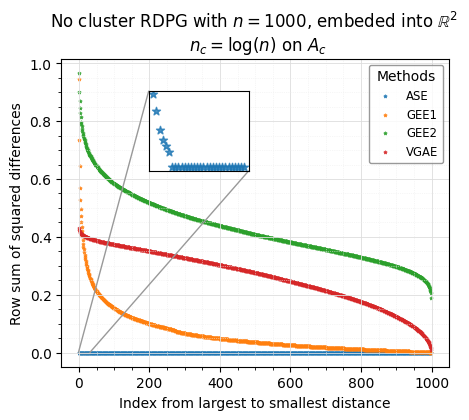

In [91]:

fig, ax = plt.subplots(figsize=(5, 4))

ax.grid(True)
ax.grid(which='major', color='#DDDDDD', linewidth=0.6)
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax.minorticks_on()
ax.set_xlabel('Index from largest to smallest distance')
ax.set_ylabel('Row sum of squared differences')
ax.set_title('No cluster RDPG with $n=1000$, embeded into $\mathbb{R}^2$ \n $n_c =\log(n)$ on $A_c$', ###_______________________
             fontsize=12)

plt.scatter(indexs,sortedASE,marker = '*',color = '#1f77b4',alpha = 0.8,s = 4,label = "ASE")
plt.scatter(indexs,sorted_GEE1,marker = '*',color = '#ff7f0e',alpha = 0.8,s = 4,label = "GEE1")
plt.scatter(indexs,sorted_GEE2,marker = '*',color = '#2ca02c',alpha = 0.8,s = 4,label = 'GEE2')
plt.scatter(indexs,sorted_GAE,marker = '*',color = '#d62728',alpha = 0.8,s = 4,label = "VGAE")

legend = plt.legend(frameon = 1,loc = 1,title="Methods",
                    fontsize='small',fancybox=True)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('grey')


a = plt.axes([0.3, 0.6, .2, .2], facecolor='w')
plt.scatter(indexzoom,zoomase,marker = '*',color = '#1f77b4',alpha = 0.8)
#plt.title('Zoomed ASE',fontsize = 'small')
plt.xticks([])
plt.yticks([])
mark_inset(ax, a, loc1=2, loc2=4, fc="none", ec="0.6")

#plt.show()
#plt.savefig('./plots/rowsum/Ac_r2_logn_zoom.png')


In [83]:
# RDPG no cluster
# calculate row sum
# R^3
# Adj clique

#nvs = np.arange(100, 1501, 200)

nvs = np.arange(1000, 1001, 2)
sim = 50
random.seed(118)

ASE_dist = []
ASE_nml = []
GEE_dist = []
GEE_nml = []
GAE_dist = []
GAE_nml = []
GEE_dist2 =[]
GEE_fnorm2 =[]
n_vs = []

GEE_fnorm = []
GAE_fnorm = []

adj0_norms = []

R3SD_afterASE = []
R3SD_afterGEE1 = []
R3SD_afterGEE2 = []
R3SD_afterGAE = []

d = 3

#sim_alldata = pd.DataFrame()
sim_alldata_nml = []

for n in nvs:
    #______________________Clique size
    ratio = 0.2      
    cliquesize =f'log(n)^2'      #!!    f'{ratio}*n'
    clique_size = math.log(n)   #math.log(n)           #   ratio*n 
    num_vertices = int(clique_size) 
    c_vertices = np.arange(0,num_vertices) 
        
    for i in range(sim):
        lpvs = np.random.dirichlet((1,1,1),n) 
        lpvs = np.delete(lpvs, 2, 1)
        g = rdpg(lpvs,loops=False)
        g.astype(int)
        adj0 = csr_array(g)
        graph0 = nx.from_numpy_matrix(g,parallel_edges=False, create_using=None)
        
        adj0_norm = sp.linalg.norm(adj0)
        adj0_norms.append(adj0_norm)

#         ########## change clique size ##################################
#         ratio = 0.2      
#         cliquesize =f'log(n)^2'      #!!    f'{ratio}*n'
#         clique_size = ratio*n   #math.log(n)           #   ratio*n 
#         num_vertices = int(clique_size) 
#         #################  change location of vertices##################
#         c_vertices = np.arange(0,num_vertices)  
#         #c_vertices = np.arange(n-num_vertices,n)  
#         #c_vertices = random.sample(range(0,n),num_vertices)
        ################################################################
        full_g = nx.complete_graph(c_vertices)
        
        full_edges = list(full_g.edges())
        edges = list(graph0.edges()) 
        all_edges = set(full_edges).union(set(edges))
        
        graph1 = nx.Graph()
        graph1.add_nodes_from(sorted(graph0.nodes(data=True)))
        graph1.add_edges_from(all_edges)
        
        adj1 = nx.to_numpy_array(graph1, dtype=int)

        ##############  ASE  ######################3
        d = d
        ase = AdjacencySpectralEmbed(n_components=d, algorithm='truncated')
        ASE_Xhat0 = ase.fit_transform(adj0)

        ASE_Xhat1 = ase.fit_transform(adj1)

        #pairplot(Xhat0, title='2-component embedding', height=2)
        ASE_d = procrustes(ASE_Xhat1,ASE_Xhat0)
        ASE_dd = ASE_d['error']
        ASE_dist.append(ASE_dd)
        
#         ASE_n = ASE_dd/adj0_norm
#         ASE_nml.append(ASE_n)

        ############## row sum after ASE
        
        row_1 = np.sum((ASE_Xhat0 - ASE_Xhat1.dot(ASE_d['W']))**2, axis=1)
        R3SD_afterASE.append(row_1)

        ############ GEE ##################
        edgelist0 = adj_to_edg(adj0)
        i_graph0 = ig.Graph.from_networkx(graph0)
        y0 = la.find_partition(i_graph0, la.ModularityVertexPartition)
        #y0 = la.find_partition(i_graph0,la.CPMVertexPartition,resolution_parameter = 0.015)
        label_num = []
        for k in range(len(y0)):
            y = len(y0[k])
            label_num.append(y)
        values = np.arange(len(label_num))
        label0 = np.repeat(values, label_num) 
        label0= label0.reshape((n,1))
        Z0,W0 = graph_encoder_embed(edgelist0,label0,n,correlation=False)

        edgelist1 = adj_to_edg(adj1)
        i_graph1 = ig.Graph.from_networkx(graph1)
        n_comms = len(label_num)
        y1 = la.CPMVertexPartition(i_graph1,initial_membership=np.random.choice(n_comms, n),
                           resolution_parameter=0.5)
        
        label_num1 = []
        for j in range(len(y1)):
            y = len(y1[j])
            label_num1.append(y)
        values1 = np.arange(len(label_num1))
        label1 = np.repeat(values1, label_num1) 
        label1= label1.reshape((n,1))
        Z1,W1 = graph_encoder_embed(edgelist1,label1,n,correlation=False) #!!!!!!!!!!!!!!!!

        GEE_d = procrustes(Z1,Z0)
        GEE_dd = GEE_d['error']
        GEE_dist.append(GEE_dd)
        
#         GEE_n = GEE_dd/adj0_norm
#         GEE_nml.append(GEE_n)
        
#         GEE_fd = np.linalg.norm(Z0 - Z1, "fro")
#         GEE_fnorm.append(GEE_fd)
        
        y000 = la.find_partition(i_graph0,la.CPMVertexPartition,resolution_parameter = 0.4)
        label_numppp = []
        for k in range(len(y000)):
            y = len(y000[k])
            label_numppp.append(y)
        values = np.arange(len(label_numppp))
        label000 = np.repeat(values, label_numppp) 
        label000= label000.reshape((n,1))
        Z000,W000 = graph_encoder_embed(edgelist0,label000,n,correlation=False)#,emb_opt='AEE')

        edgelist1 = adj_to_edg(adj1)
        i_graph1 = ig.Graph.from_networkx(graph1)
        n_comms = len(label_numppp)
        y111 = la.CPMVertexPartition(i_graph1,initial_membership=np.random.choice(n_comms, n),
                           resolution_parameter=0.5)
        
        label_num1ttt = []
        for j in range(len(y111)):
            y = len(y111[j])
            label_num1ttt.append(y)
        values1 = np.arange(len(label_num1ttt))
        label111 = np.repeat(values1, label_num1ttt) 
        label111= label111.reshape((n,1))
        Z111,W111 = graph_encoder_embed(edgelist1,label111,n,correlation=False) #!!!!!!!!!!!!!!!!!!!!
        
        GEE_dd = procrustes(Z111,Z000)
        GEE_ddd = GEE_dd['error']
#         GEE_dist2.append(GEE_ddd)

#         GEE_fd2 = np.linalg.norm(Z000 - Z111, "fro")
#         GEE_fnorm2.append(GEE_fd2)
        
        ############## row sum after GEE
        
        row_2 = np.sum((Z0 - Z1.dot(GEE_d['W']))**2, axis=1)
        R3SD_afterGEE1.append(row_2)
        
        row_3 = np.sum((Z000 - Z111.dot(GEE_dd['W']))**2, axis=1)
        R3SD_afterGEE2.append(row_3)
        
        ############### VGAE ################
        dim = d
        features = torch.eye(n)
        model_GAE = GCNModelVAE(n, 2*dim, dim, 0) #init new instance everytime. Can change 0 to other dropout rates
        
        adj0 = nx.to_numpy_array(graph0, dtype=int)
        adj_norm_matrix0, adj_matrix0, adj_label0 = adj_in_out(adj0)
        GAE_0 = GCN_emb(model_GAE, features, adj_norm_matrix0, adj_label0,n,decay=0, learning_rate=1e-2) #initial benchmark: decay = 1e-3; investigate 0 weight decay w/ dropout on 
        GAE_0 = GAE_0.numpy()
        adj1 = nx.to_numpy_array(graph1, dtype=int)
        adj_norm_matrix1, adj_matrix1, adj_label1 = adj_in_out(adj1)
        GAE_1 = GCN_emb(model_GAE, features, adj_norm_matrix1, adj_label1,n,decay=0, learning_rate=1e-2) #initial benchmark: decay = 1e-3; investigate 0 weight decay w/ dropout on 
        GAE_1 = GAE_1.numpy()
#         GAE_d = procrustes(GAE_1,GAE_0)
#         GAE_d = GAE_d['error']
#         GAE_dist.append(GAE_d)
        
#         GAE_n = GAE_d/adj0_norm
#         GAE_nml.append(GAE_n)
        
#         GAE_fd = np.linalg.norm(GAE_0 - GAE_1, "fro")
#         GAE_fnorm.append(GAE_fd)
        
        row_4 = np.sum((GAE_0 - GAE_1)**2, axis=1)
        R3SD_afterGAE.append(row_4)
        
        n_vs.append(n)
        
           
#     sim_data = np.column_stack((ASE_dist, GEE_dist,GAE_dist,
#                                 ASE_nml,GEE_nml,GAE_nml,n_vs,GEE_fnorm,GAE_fnorm))
#     sim_data = pd.DataFrame(sim_data, columns = ['ASE_dist','GEE_dist','GAE_dist',
#                                                  'ASE_nml','GEE_nml','GAE_nml','n','GEE_fnorm','GAE_fnorm'])
    
#     df_id = n.astype(str)
    #sim_data.to_csv("./sim_data/new_sim/rdpg_0.2n"+cliquesize+df_id+".csv", sep=',', index=False)
    
# sim_alldata_nml.append(sim_data)


#print(sim_alldata_nml)



GCNModelVAE(
  (gc1): GraphConvolution (1000 -> 6)
  (gc2): GraphConvolution (6 -> 3)
  (gc3): GraphConvolution (6 -> 3)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun
GCNModelVAE(
  (gc1): GraphConvolution (1000 -> 6)
  (gc2): GraphConvolution (6 -> 3)
  (gc3): GraphConvolution (6 -> 3)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun
GCNModelVAE(
  (gc1): GraphConvolution (1000 -> 6)
  (gc2): GraphConvolution (6 -> 3)
  (gc3): GraphConvolution (6 -> 3)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun


In [84]:
test1 = []
for x in R3SD_afterASE:
    tt = np.sort(x)
    test1.append(tt)

p1=np.mean(test1,axis=0)
sorted3ASE = np.sort(p1)[::-1]


test2 = []
for x in R3SD_afterGEE1:
    tt = np.sort(x)
    test2.append(tt)

p2=np.mean(test2,axis=0)
sorted3_GEE1 = np.sort(p2)[::-1]
    
test3 = []
for x in R3SD_afterGEE2:
    tt = np.sort(x)
    test3.append(tt)

p3=np.mean(test3,axis=0)
sorted3_GEE2 = np.sort(p3)[::-1]

test4 = []
for x in R3SD_afterGAE:
    tt = np.sort(x)
    test4.append(tt)

p4=np.mean(test4,axis=0)
sorted3_GAE = np.sort(p4)[::-1]
    

In [85]:
# CAUTION store values
Ac_r3_logn = [test1,test2,test3,test4]

In [45]:
# CAUTION store values
Ac_r3_02n = [test1,test2,test3,test4]

In [86]:
# draw the zoomed part 
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

zoomase = sortedASE[0:30]
indexzoom = list(range(len(zoomase)))



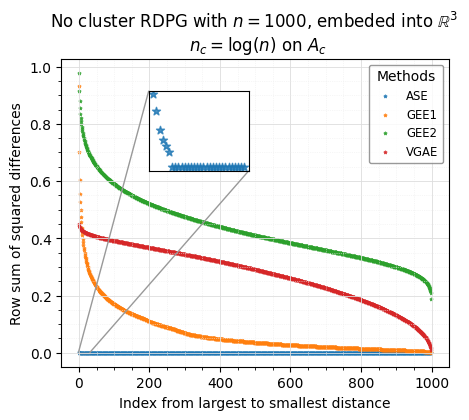

In [89]:
fig, ax = plt.subplots(figsize=(5, 4))

ax.grid(True)
ax.grid(which='major', color='#DDDDDD', linewidth=0.6)
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax.minorticks_on()
ax.set_xlabel('Index from largest to smallest distance')
ax.set_ylabel('Row sum of squared differences')
ax.set_title('No cluster RDPG with $n=1000$, embeded into $\mathbb{R}^3$ \n $n_c = \log(n)$ on $A_c$', ###_______________________
             fontsize=12)

plt.scatter(indexs,sorted3ASE,marker = '*',color = '#1f77b4',alpha = 0.8,s = 4,label = "ASE")
plt.scatter(indexs,sorted3_GEE1,marker = '*',color = '#ff7f0e',alpha = 0.8,s = 4,label = "GEE1")
plt.scatter(indexs,sorted3_GEE2,marker = '*',color = '#2ca02c',alpha = 0.8,s = 4,label = 'GEE2')
plt.scatter(indexs,sorted3_GAE,marker = '*',color = '#d62728',alpha = 0.8,s = 4,label = "VGAE")

legend = plt.legend(frameon = 1,loc = 1,title="Methods",
                    fontsize='small',fancybox=True)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('grey')

a = plt.axes([0.3, 0.6, .2, .2], facecolor='w')
plt.scatter(indexzoom,zoomase,marker = '*',color = '#1f77b4',alpha = 0.8)
#plt.title('Zoomed ASE',fontsize = 'small')
plt.xticks([])
plt.yticks([])
mark_inset(ax, a, loc1=2, loc2=4, fc="none", ec="0.6")


#plt.show()
#plt.savefig('./plots/rowsum/Ac_r3_logn_zoom.png')